In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pytorch_lightning import seed_everything, LightningModule, Trainer
from sklearn.utils import class_weight
import torch.nn as nn
import torch
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau,CosineAnnealingWarmRestarts,OneCycleLR,CosineAnnealingLR
import torchvision
from sklearn.metrics import classification_report,f1_score,accuracy_score
from PIL import Image
from torch.utils.data import DataLoader, Dataset,random_split
import timm
import torchmetrics
import torchvision.models as models

In [2]:
img_size=224
import albumentations as A
from albumentations.pytorch import ToTensorV2
aug= A.Compose([
            A.Resize(img_size,img_size),
            #A.RandomCrop(img_size,img_size),
            A.HorizontalFlip(0.5),
            A.VerticalFlip(),
            A.RandomRotate90(),
#             A.ShiftScaleRotate(rotate_limit=3),
            #A.CoarseDropout(8,64,64),
            A.Normalize(),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [3]:
class DataReader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x=self.dataset[index][0]
        y=self.dataset[index][1]
        if self.transform:
            x=np.array(x)
            x=self.transform(image=x)['image']
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [4]:
class LabelSmoothing(nn.Module):
    """NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.0):
        """Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target):
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()


In [5]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2,alpha=0.5):
        super(FocalLoss, self).__init__()
        self.gamma=gamma
        self.alpha=alpha

    def forward(self,outputs,targets):
        ce_loss = torch.nn.functional.cross_entropy(outputs, targets, reduction='none') # important to add reduction='none' to keep per-batch-item loss
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1-pt)**self.gamma * ce_loss).mean()
        return focal_loss

In [6]:
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel,self).__init__()
        #architecute
        self.model =  timm.create_model(model_name,pretrained=True)
        self.fc1=nn.Linear(1000,500)
        self.relu=nn.ReLU()
        self.fc2= nn.Linear(500,5)
 
        #parameters
        self.lr=1e-3
        self.batch_size=64
        self.numworker=12
        self.acc = torchmetrics.Accuracy()
        self.criterion=LabelSmoothing()
        
        self.trainacc,self.valacc=[],[]
        self.trainloss,self.valloss=[],[]
        
        self.scheduler='warm'
        
        self.dataset=torchvision.datasets.ImageFolder('dataset')
        
        self.train_set, self.val_set =random_split(self.dataset, 
                            [int(len(self.dataset)*0.7), int(len(self.dataset)*0.3)])
    def forward(self,x):
        x= self.model(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        return x

    def configure_optimizers(self):
        opt=torch.optim.AdamW(params=self.parameters(),lr=self.lr )
        if self.scheduler=='cosine':
            scheduler=CosineAnnealingLR(opt,T_max=10,  eta_min=1e-6, last_epoch=-1)
            return {'optimizer': opt,'lr_scheduler':scheduler}
        elif self.scheduler=='reduce':
            scheduler=ReduceLROnPlateau(opt,mode='min', factor=0.5, patience=5)
            return {'optimizer': opt,'lr_scheduler':scheduler,'monitor':'val_loss'}
        elif self.scheduler=='warm':
            scheduler=CosineAnnealingWarmRestarts(opt,T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)
            return {'optimizer': opt,'lr_scheduler':scheduler}
        elif self.scheduler=='constant':
            return opt
 
    def train_dataloader(self):
        return DataLoader(DataReader(self.train_set,aug), batch_size = self.batch_size, 
                          num_workers=self.numworker,
                          pin_memory=True,shuffle=False)

    def training_step(self,batch,batch_idx):
        image,label=batch
        out = self(image)
        loss=self.criterion(out,label)
        acc=self.acc(out,label)
        return {'loss':loss,'acc':acc}

    def training_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.trainacc.append(acc)
        self.trainloss.append(loss)
        #print('training loss accuracy ',self.current_epoch,loss, acc)
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        
    def val_dataloader(self):
        ds=DataLoader(DataReader(self.val_set,aug), batch_size = self.batch_size,
                      num_workers=self.numworker,pin_memory=True, shuffle=False)
        return ds

    def validation_step(self,batch,batch_idx):
        image,label=batch
        out=self(image)
        loss=self.criterion(out,label)
        acc=self.acc(out,label)
        return {'loss':loss,'acc':acc}

    def validation_epoch_end(self, outputs):
        loss=torch.stack([x["loss"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        acc=torch.stack([x["acc"] for x in outputs]).mean().detach().cpu().numpy().round(2)
        self.valacc.append(acc)
        self.valloss.append(loss)
        print('validation loss accuracy ',self.current_epoch,loss, acc)
        self.log('val_loss', loss)
        self.log(''val_acc'', acc)

In [7]:
model_name='resnest50d'
model=OurModel()

In [8]:
lr_monitor = LearningRateMonitor(logging_interval='epoch')
checkpoint=ModelCheckpoint(filename='file', monitor='val_acc', verbose=False, save_last=True, mode='max')
trainer = Trainer(max_epochs=50, auto_lr_find=False, auto_scale_batch_size=False,
                #deterministic=True,
                gpus=-1,precision=16,
                accumulate_grad_batches=1,
                stochastic_weight_avg=False,
                enable_progress_bar = False,
                num_sanity_val_steps=0,
                callbacks=[lr_monitor]
                 )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [9]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2021-12-07 09:37:04.478332: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

  | Name      | Type           | Params
---------------------------------------------
0 | model     | ResNet         | 27.5 M
1 | fc1       | Linear         | 500 K 
2 | relu      | ReLU           | 0     
3 | fc2       | Linear         | 2.5 K 
4 | acc       | Accuracy       | 0     
5 | criterion | LabelSmoothing | 0     
---------------------------------------------
28.0 M    Trainable params
0         Non-trainable params
28.0 M    Total params
55.972    Total estimated model params size (MB)


validation loss accuracy  0 2.16 0.34
validation loss accuracy  1 1.01 0.56
validation loss accuracy  2 0.92 0.59
validation loss accuracy  3 0.85 0.64
validation loss accuracy  4 0.84 0.64
validation loss accuracy  5 0.84 0.65
validation loss accuracy  6 0.76 0.68
validation loss accuracy  7 0.73 0.69
validation loss accuracy  8 0.71 0.7
validation loss accuracy  9 0.7 0.71
validation loss accuracy  10 1.57 0.43
validation loss accuracy  11 0.91 0.62
validation loss accuracy  12 0.8 0.66
validation loss accuracy  13 0.8 0.67
validation loss accuracy  14 0.77 0.67
validation loss accuracy  15 0.76 0.68
validation loss accuracy  16 0.71 0.7
validation loss accuracy  17 0.7 0.7
validation loss accuracy  18 0.68 0.72
validation loss accuracy  19 0.69 0.71
validation loss accuracy  20 0.99 0.62
validation loss accuracy  21 0.9 0.63
validation loss accuracy  22 0.89 0.63
validation loss accuracy  23 0.73 0.7
validation loss accuracy  24 0.75 0.68
validation loss accuracy  25 0.71 0.71
valid

Text(0.5, 1.0, 'accuracy')

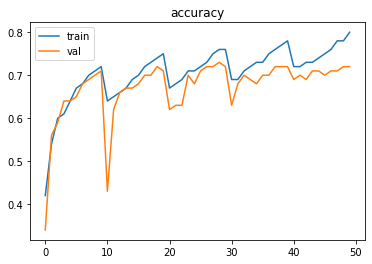

In [10]:
plt.plot(model.trainacc,label='train')
plt.plot(model.valacc,label='val')
plt.legend()
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

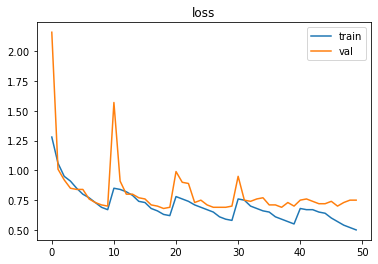

In [11]:
plt.plot(model.trainloss,label='train')
plt.plot(model.valloss,label='val')
plt.legend()
plt.title('loss')

In [12]:
trainer.validate(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


validation loss accuracy  49 0.74 0.72
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.7200000286102295, 'val_loss': 0.7400000095367432}
--------------------------------------------------------------------------------


[{'val_loss': 0.7400000095367432, 'val_acc': 0.7200000286102295}]

In [13]:
loader=model.val_dataloader()
model.cuda().eval()
labels,preds=[],[]
with torch.no_grad():
    for batch in loader:
        image,label=batch
        pred=model(image.cuda())
        pred=torch.argmax(pred,dim=1).detach().cpu().numpy()
        labels.append(label.cpu().numpy())
        preds.append(pred)

In [14]:
from sklearn.metrics import classification_report
print(classification_report(np.hstack(labels),np.hstack(preds)))

              precision    recall  f1-score   support

           0       0.67      0.94      0.78      1006
           1       0.80      0.66      0.72       934
           2       0.66      0.70      0.68       870
           3       0.73      0.62      0.67       917
           4       0.82      0.69      0.75       923

    accuracy                           0.72      4650
   macro avg       0.74      0.72      0.72      4650
weighted avg       0.74      0.72      0.72      4650



In [15]:
import ttach as tta
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.VerticalFlip(),
        tta.Rotate90(angles=[0, 90,180]),
    ]
)

tta_model = tta.ClassificationTTAWrapper(model, transforms)

In [16]:
loader=model.val_dataloader()
model.cuda().eval()
labels,preds=[],[]
with torch.no_grad():
    for batch in loader:
        image,label=batch
        pred=tta_model(image.cuda())
        pred=torch.argmax(pred,dim=1).detach().cpu().numpy()
        labels.append(label.cpu().numpy())
        preds.append(pred)

In [17]:
from sklearn.metrics import classification_report
print(classification_report(np.hstack(labels),np.hstack(preds)))

              precision    recall  f1-score   support

           0       0.69      0.95      0.80      1006
           1       0.81      0.67      0.73       934
           2       0.67      0.71      0.69       870
           3       0.73      0.63      0.68       917
           4       0.82      0.69      0.75       923

    accuracy                           0.73      4650
   macro avg       0.74      0.73      0.73      4650
weighted avg       0.74      0.73      0.73      4650

